# Usvyatsov Mikhail HW1

In [1]:
#Tech stuff
from scipy.io import wavfile
from scipy.signal import resample
import numpy as np
import sys
%matplotlib inline

def load_wav(filename,samplerate=44100):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return samplerate, data.astype(np.int16)

In [2]:
#Reading the wavefile
import StringIO
import base64
import struct  

from IPython.core.display import HTML
from IPython.core.display import display

def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

# Problem 1 (Python demo: convolution of a signal)

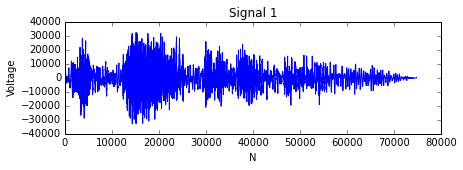

In [4]:
#The first sound
import pylab as pl
import numpy as np
# load
fs1,s1 = load_wav('../nla2015/lectures/tbawht02.wav') # Terran Battlecruiser - "Good day, commander."

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s1)
pl.title('Signal 1')
pl.ylabel('Voltage')
pl.xlabel('N')
pl.show()

# player
wavPlayer(s1, fs1)

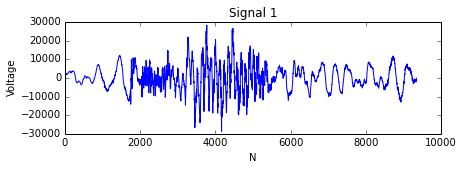

In [5]:
N = len(s1) / 8
s2 = s1[0:N]

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s2)
pl.title('Signal 1')
pl.ylabel('Voltage')
pl.xlabel('N')
pl.show()

# player
wavPlayer(s2, fs1)

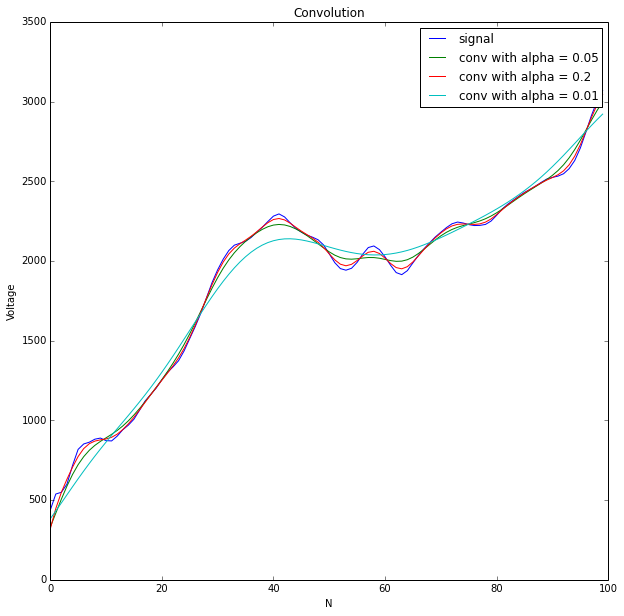

In [6]:
def make_T(alpha, N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    return np.sqrt(alpha / np.pi) * np.exp(-alpha * (i - j) ** 2)
   
pl.figure(figsize=(10,10))
pl.plot(s2[0:100], label='signal')
pl.title('Convolution')
convolutions = []

for alpha in [1 / 20.0, 1 / 5.0, 1 / 100.0]:
    T = make_T(alpha, N)
    convolution = T.dot(s2)

    pl.plot(convolution[0:100], label='conv with alpha = {0}'.format(alpha))
    convolutions.append(convolution)
    
pl.legend(loc='upper right')
pl.ylabel('Voltage')
pl.xlabel('N')
pl.show()

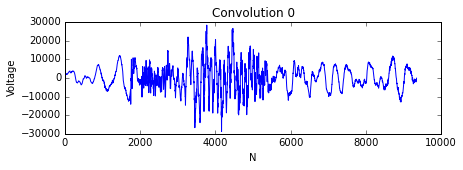

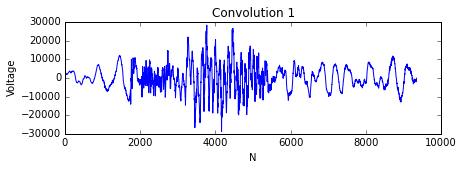

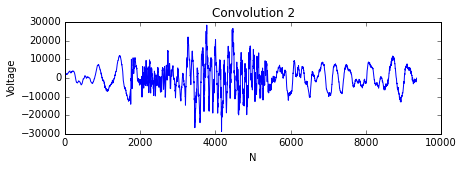

In [12]:
for i, convolution in enumerate(convolutions):
    # plot
    pl.figure(figsize=(6.75,2))
    pl.plot(s2)
    pl.title('Convolution {0}'.format(i))
    pl.ylabel('Voltage')
    pl.xlabel('N')
    pl.show()
    
    wavPlayer(convolution.astype(np.int16), fs1)

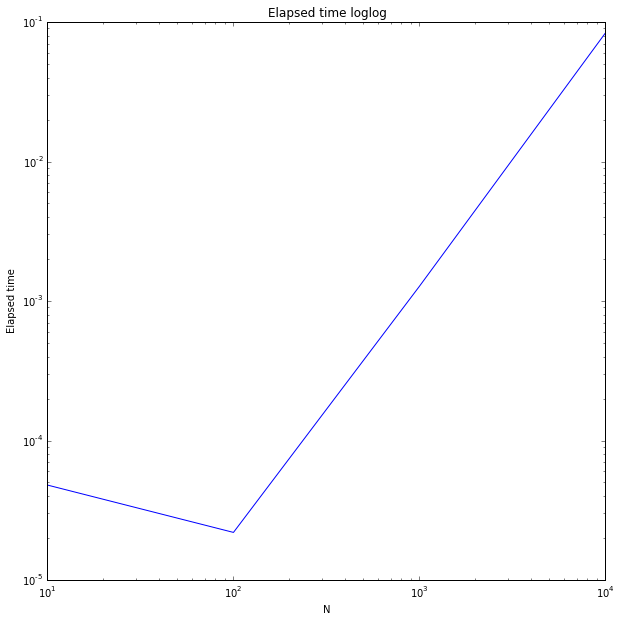

In [16]:
import time 
import matplotlib.pyplot as plt
   
sizes = [10 ** i for i in range(1, 5)]

timings = []

plt.figure(figsize=(10,10))
plt.title('Elapsed time loglog')
plt.yscale('log')
plt.xscale('log')

for n in sizes:
    T = make_T(0.2, n)
    start_time = time.time()
    T.dot(s1[0:n])
    timings.append(time.time() - start_time)
    
plt.plot(sizes, timings)
plt.ylabel('Elapsed time')
plt.xlabel('N')


    
    

    The slope of the previous graphic has linear dependancy and it is beacuse its O(N^2) complexity of multiplication with Toeplitz matrix. Logariphm of this value gives us exactly linear dependancy of N.

# Problem 2 (Instability of the standard Gram-Schmidt algorithm)

In [191]:
def gs(v):
    u = np.array([v[0]])

    for i in range(1, len(v)):
        u_i = v[i]
        
        for j in range(i):
            u_i -= u[j] * (np.dot(v[i], u[j]) / float(np.dot(u[j], u[j])))

        u = np.concatenate((u, np.array([u_i])))
        
    for i in range(len(u)):
        u[i] = u[i] / np.linalg.norm(u[i])
        
    return u

In [192]:
N = 10

random_matrix = np.random.random((N, N))
U = gs(random_matrix)

G = np.ones((N, N))

for i in range(len(U)):
    for j in range(len(U[0])):
        G[i][j] = np.dot(U[i], U[j])

np.linalg.norm(G - np.eye(N))

8.750984670758485e-15

In [207]:
i, j = np.meshgrid(np.arange(N), np.arange(N))
H = 1 / (i + j + 1.0)
U = gs(H)

for i in range(len(U)):
    for j in range(len(U[0])):
        G[i][j] = np.dot(U[i], U[j])

np.linalg.norm(G - np.eye(N))

0.00011798085629570054

The problem in this case is a huge error in arithmetic due to rounding error

#Problem 3 (Unitary invariance of norms)

By the defenition of U: $\|Ux\|_2 = \sqrt{ < Ux, Ux > } = \sqrt{ < x, x > } = \|x\|_2$ for any vector x.

$\|UAV\|_2 = \|AV\|_2$ the same way it was proved before.
Now we have to prove $\|AV\|_2 = \|A\|_2$

$\|AV\|_2 = sup _ {x \neq 0 } \dfrac{\|AVx\|_2}{\|x\|_2}$ by the definition of the matrix norm.

We can define $x = V^{-1} y$. We can do this because of:
$sup _{x\neq = 0} f(x) = sup_{y\neq 0} f(V^{-1}y)$ from which we can derrive that if x = 0 then y = 0 also.

So $sup _ {x \neq 0 } \dfrac{\|AVx\|_2}{\|x\|_2} = sup _ {y \neq 0 } \dfrac{\|AVV^{-1}y\|_2}{\|V^{-1}y\|_2} = sup _ {y \neq 0 } \dfrac{\|Ay\|_2}{\|V^{-1}y\|_2}$

It was already proved, that $\|V^{-1}y\|_2 = \|y\|_2$ and finally it means, that $sup _ {y \neq 0 } \dfrac{\|Ay\|_2}{\|V^{-1}y\|_2} = \|A\|_2$ QED

By the defenition of Frobenius norm $\|A\|_F =\sqrt{\Sigma^m_{i=1}\Sigma^n_{j = 1}|a_{ij}|^2}$
So we can rewrite this as $|A|_F = \sqrt{trace(A^*A)}$

$|A|^2_F = trace(A^*A) = trace(AA^*)$ according to the definition of the conjugation definition.

$|A|^2_F = trace(UAV(UAV)^T) = trace(UAV U^TA^TV^T)$ 

# Problem 4 (Bonus)